In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 28 03:08:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 指定当前的工作文件夹
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("/content/drive/MyDrive/AttentiveFP/code/")

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge rdkit

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...

Looking for: ['rdkit']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   8%
conda-forge/noarch     9%[+] 0.3s
conda-forge/linux-64  18%
conda-forge/noarch    43%[+] 0.4s
conda-forge/linux-64  28%
conda-forge/noarch    43%[+] 0.5s
conda-forge/linux-64  33%
conda-forge/noarch    79%[+] 0.6s
conda-forge/linux-64  38%
conda-forge/noarch    79%conda-forge/noarch                                
[+] 0.7s
conda-forge/linux-64  48%[+] 0.8s
conda-forge/linux-64  58%[+] 0.9s
conda-forge/linux-64  68%[+] 1.0s
conda-forge/linux-64  88%conda-forge/linux-64                              

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /u

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [ ]:
import random
from rdkit.Chem import rdMolDescriptors, MolSurf, rdDepictor
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  2928
number of successfully processed smiles:  2928


<ipython-input-7-02f54730ef72>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(atom_num_dist, bins=28, kde=False)


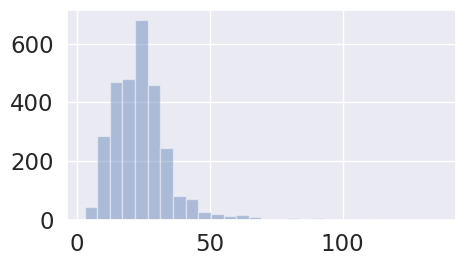

In [ ]:
task_name = 'Anti'
tasks = ['Anti']
raw_filename = "../data/Anti_plus_v2.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
#print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [ ]:
smiles_tasks_df

,Anti,smiles,cas,cano_smiles
0,0,S=P(N1CC1)(N1CC1)N1CC1,2621,S=P(N1CC1)(N1CC1)N1CC1
1,0,S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1,2620,S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1
2,0,S=c1[nH]cnc2nc[nH]c12,2619,S=c1[nH]cnc2nc[nH]c12
3,0,S=C=NCc1ccccc1,2618,S=C=NCc1ccccc1
4,0,S=C=Nc1ccc(N=C=S)cc1,2617,S=C=Nc1ccc(N=C=S)cc1
...,...,...,...,...
2923,0,Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1,5,Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1
2924,0,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1
2925,0,[O-][n+]1cccc(CO)c1,3,[O-][n+]1cccc(CO)c1
2926,0,[O-][N+](=O)c1ncc[nH]1,2,O=[N+]([O-])c1ncc[nH]1


In [ ]:
random_seed = 88
#random_seed = int(time.time())
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 500
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Anti,smiles,cas,cano_smiles
608,0,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+],2071,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]


In [ ]:
weights = []
for i,task in enumerate(tasks):
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# train_df.to_csv("trainset.csv",index=False)
# test_df.to_csv("testset.csv",index=False)

In [ ]:
test_df[test_df[task] == 1][["smiles",task]]

,smiles,Anti
3,CCCCCCCCCCCCCCCCCC[N+](C)(C)C,1
7,O1[n+]2ccccc2S[Zn]11O[n+]2ccccc2S1,1
10,COc1ccc2c(c1OC)C(=O)OC2C1c2c(cc3c(c2OC)OCO3)CC...,1
34,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,1
36,Cc1nnc(SCC2=C(C(=O)[O-])N3C(=O)C(NC(=O)Cn4cnnn...,1
39,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,1
44,CCCCCCCCCCCCCC[N+](C)(C)CC,1
83,CC(=O)OCC1=C(C(=O)[O-])N2C(=O)C(NC(=O)Cc3cccs3...,1
105,Cl.O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)c...,1
106,Cl.NC1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2...,1


In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)


649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())

        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()

    test_cm1 = [confusion_matrix(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]

    test_cm2 = [confusion_matrix(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.7).astype(int)) for i in range(len(tasks))]
    test_roc_curve = [roc_curve(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc_curve = [precision_recall_curve(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    return test_roc, test_prc, test_precision, test_recall, test_loss, test_cm1, test_cm2, test_roc_curve, test_prc_curve

In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):
    train_roc, train_prc, train_precision, train_recall, train_loss, test_cm1, test_cm2, test_roc_curve, test_prc_curve = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss, valid_cm1, valid_cm2, valid_roc_curve, valid_prc_curve = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()

#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.90:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_loss"+":"+str(train_loss)+'\n'\
        +"valid_loss"+":"+str(valid_loss)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):
         break

    train(model, train_df, optimizer, loss_function)


In [ ]:
# evaluate model
#best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model = torch.load('saved_models/model_Anti_plus_v2_Sun_Jun_11_14-41-40_2023_153'+'.pt')

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_precision, test_recall, test_losse, test_cm1, test_cm2, test_roc_curve, test_prc_curve = eval(best_model, test_df)
#test_fpr, test_tpr, test_threshold  = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_prc:"+str(test_prc)
      +"\n"+"cm1:",test_cm1
     )
best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)


In [ ]:
import pandas as pd

train_dataset = pd.read_csv('Anti_plus_v2_train_ROC.csv')
y_train= train_dataset.loc[:, 'Anti'].values
y_train_pre = train_dataset.loc[:, 'y_pred_adjust'].values

In [ ]:
train_dataset

,SMILES,y_pred_adjust,CAS,Anti
0,S=P(N1CC1)(N1CC1)N1CC1,0.002490,2621,0
1,S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1,0.029002,2620,0
2,S=c1[nH]cnc2nc[nH]c12,0.187912,2619,0
3,S=C=NCc1ccccc1,0.095568,2618,0
4,S=C=Nc1ccc(N=C=S)cc1,0.125164,2617,0
...,...,...,...,...
2325,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,0.228305,6,0
2326,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,0.004318,4,0
2327,[O-][n+]1cccc(CO)c1,0.305345,3,0
2328,O=[N+]([O-])c1ncc[nH]1,0.528222,2,0


In [ ]:
test_dataset = pd.read_csv('Anti_plus_v2_test_ROC.csv')
y_test= test_dataset.loc[:, 'Anti'].values
y_test_pre = test_dataset.loc[:, 'y_pred_adjust'].values

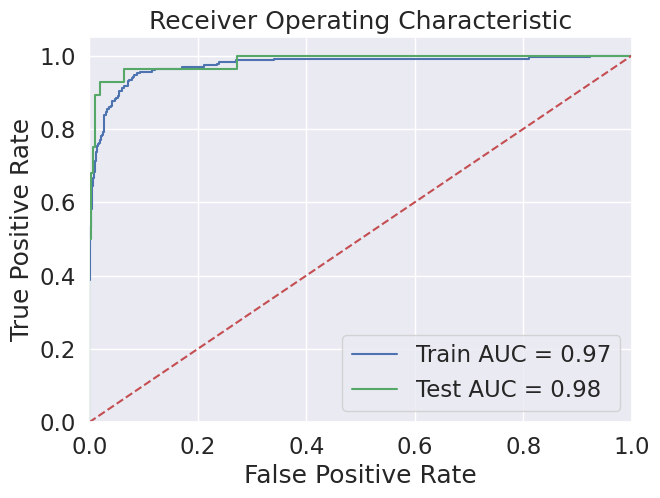

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[7,5])
# calculate the fpr and tpr for all thresholds of the classification
train_fpr, train_tpr, train_threshold = roc_curve(y_train, y_train_pre)
test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_test_pre)

train_roc_auc = auc(train_fpr, train_tpr)
test_roc_auc = auc(test_fpr, test_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg",dpi=1200) #.png,.pdf will also support here
plt.show()


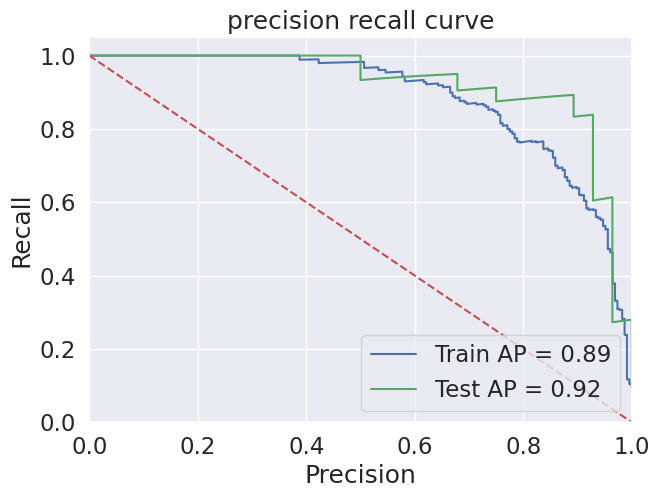

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
fig, ax = plt.subplots(figsize=[7,5])
# calculate the fpr and tpr for all thresholds of the classification
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_pre)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pre)

train_ap = average_precision_score(y_train, y_train_pre)
test_ap = average_precision_score(y_test, y_test_pre)

plt.title('precision recall curve')
plt.plot(train_recall, train_precision, 'b', label = 'Train AP = %0.2f' % train_ap)
plt.plot(test_recall, test_precision, 'g', label = 'Test AP = %0.2f' % test_ap)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.savefig("PRC.svg",dpi=1200) #.png,.pdf will also support here
plt.show()

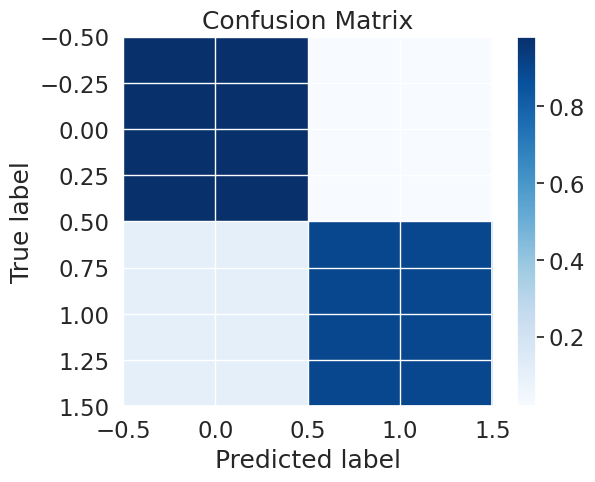

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title('Confusion Matrix')    # 图像标题
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.svg",dpi=1200) #.png,.pdf will also support here

# 2. Confusion Matrix
y_pick = y_test_pre
predict = []
for i in range (len(y_test_pre)):
    if y_pick[i] > 0.70:
        predict.append(1)
    else:
        predict.append(0)
y_predict = np.array(predict)
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm)

In [ ]:
print("cm:",cm)

cm: [[259   5]
 [  3  25]]


In [ ]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("cm:",cm)

cm: [[0.98106061 0.01893939]
 [0.10714286 0.89285714]]


In [ ]:
def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list

In [ ]:
# PBT_df = pd.read_csv('/content/drive/MyDrive/AttentiveFP/data/PBT_external.csv')
# PBT_feature_filename = "../data/PBT_test.pickle"
# PBT_feature_dicts = pickle.load(open(PBT_feature_filename, "rb" ))

In [ ]:
raw_filename = "../data/QAC_Anti2.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
#print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

number of all smiles:  57
number of successfully processed smiles:  57


In [ ]:
canonical_smiles_list

['CCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C',
 'CCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1',
 'CCCCCCCC[N+](C)(C)CCCCCCCC',
 'CCCCCCCCCC[N+](C)(C)CCCCCCCC',
 'CCCCCCCCCC[N+](C)(C)CCCCCCCCCC',
 'CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC',
 'CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC',
 'CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC',
 'CCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCC',
 'CCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC',
 'CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC',
 'CCCCCCCCCCCC[N+](C)(C)CC',
 'CCCCCCCCCCCCCC[N+](C)(C)CC',
 'CCCCCCCC

In [ ]:
for smiles in canonical_smiles_list:
    try:
      Chem.MolFromSmiles(smiles).GetAtoms()
    except:
      print(smiles)
    pass

In [ ]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as ../data/QAC_Anti2.pickle


,Anti,smiles,cas,cano_smiles


In [ ]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

In [ ]:
# Feature visualization

model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()



tensor(True)

In [ ]:
remained_df

,Anti,smiles,cas,cano_smiles
0,NaN,CCCCCCCC[N+](C)(C)C,1,CCCCCCCC[N+](C)(C)C
1,NaN,CCCCCCCCCC[N+](C)(C)C,2,CCCCCCCCCC[N+](C)(C)C
2,NaN,CCCCCCCCCCCC[N+](C)(C)C,3,CCCCCCCCCCCC[N+](C)(C)C
3,NaN,CCCCCCCCCCCCCC[N+](C)(C)C,4,CCCCCCCCCCCCCC[N+](C)(C)C
4,NaN,CCCCCCCCCCCCCCCC[N+](C)(C)C,5,CCCCCCCCCCCCCCCC[N+](C)(C)C
5,NaN,CCCCCCCCCCCCCCCCCC[N+](C)(C)C,6,CCCCCCCCCCCCCCCCCC[N+](C)(C)C
6,NaN,CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,7,CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
7,NaN,CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,8,CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
8,NaN,CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,9,CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
9,NaN,CCCCCCCC[N+](C)(C)CC1=CC=CC=C1,10,CCCCCCCC[N+](C)(C)Cc1ccccc1


In [ ]:
remained_df_index = remained_df.reset_index(drop=True)
remained_df_index

,Anti,smiles,cas,cano_smiles
0,NaN,CCCCCCCC[N+](C)(C)C,1,CCCCCCCC[N+](C)(C)C
1,NaN,CCCCCCCCCC[N+](C)(C)C,2,CCCCCCCCCC[N+](C)(C)C
2,NaN,CCCCCCCCCCCC[N+](C)(C)C,3,CCCCCCCCCCCC[N+](C)(C)C
3,NaN,CCCCCCCCCCCCCC[N+](C)(C)C,4,CCCCCCCCCCCCCC[N+](C)(C)C
4,NaN,CCCCCCCCCCCCCCCC[N+](C)(C)C,5,CCCCCCCCCCCCCCCC[N+](C)(C)C
5,NaN,CCCCCCCCCCCCCCCCCC[N+](C)(C)C,6,CCCCCCCCCCCCCCCCCC[N+](C)(C)C
6,NaN,CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,7,CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
7,NaN,CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,8,CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
8,NaN,CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C,9,CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C
9,NaN,CCCCCCCC[N+](C)(C)CC1=CC=CC=C1,10,CCCCCCCC[N+](C)(C)Cc1ccccc1


In [ ]:
df1 = remained_df[remained_df[task] == 1]
df1 = df1.reset_index(drop=True)
df1


,Anti,smiles,cas,cano_smiles


CAS: 1
prediction_Anti_value: 0.9608532
SMILES: CCCCCCCC[N+](C)(C)C


<ipython-input-25-84bd0cc42c48>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Oranges')
[08:08:35] The new font size 1 is below the current minimum (6).


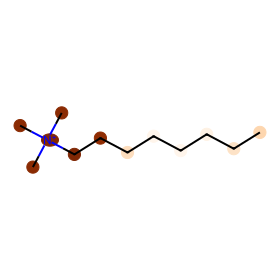

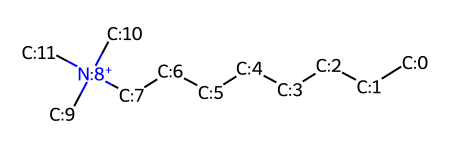

CAS: 2
prediction_Anti_value: 0.997332
SMILES: CCCCCCCCCC[N+](C)(C)C


[08:08:35] The new font size 1 is below the current minimum (6).


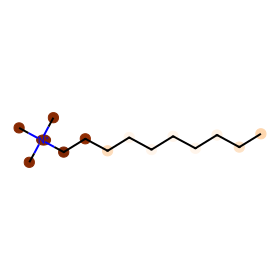

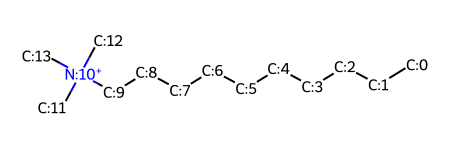

CAS: 3
prediction_Anti_value: 0.999471
SMILES: CCCCCCCCCCCC[N+](C)(C)C


[08:08:35] The new font size 1 is below the current minimum (6).


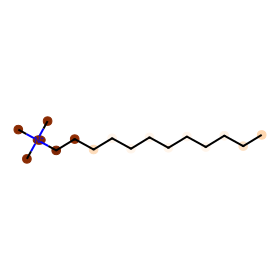

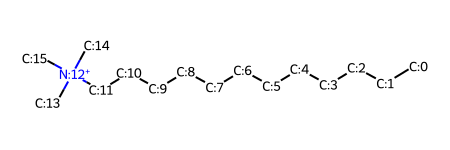

CAS: 4
prediction_Anti_value: 0.9997818
SMILES: CCCCCCCCCCCCCC[N+](C)(C)C


[08:08:35] The new font size 1 is below the current minimum (6).


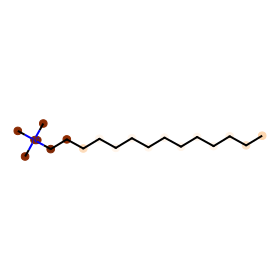

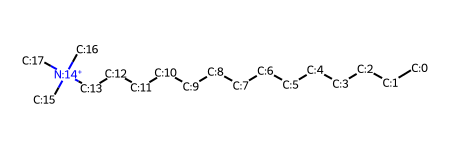

CAS: 5
prediction_Anti_value: 0.9998579
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)C


[08:08:35] The new font size 1 is below the current minimum (6).


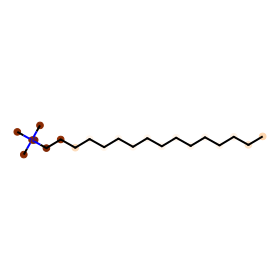

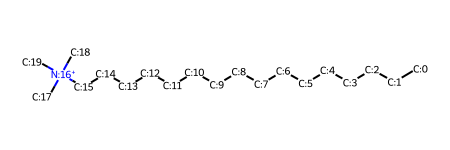

CAS: 6
prediction_Anti_value: 0.9998617
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)C


[08:08:36] The new font size 1 is below the current minimum (6).


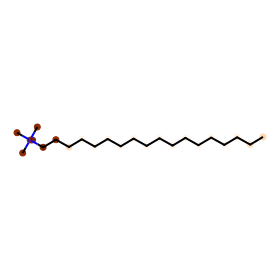

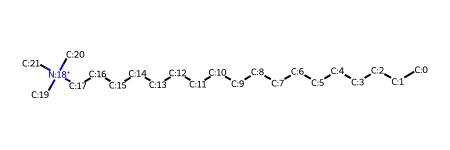

CAS: 7
prediction_Anti_value: 0.99979705
SMILES: CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[08:08:36] The new font size 1 is below the current minimum (6).


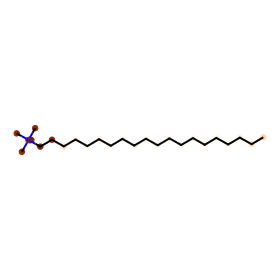

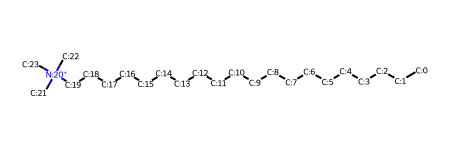

CAS: 8
prediction_Anti_value: 0.9995497
SMILES: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[08:08:36] The new font size 1 is below the current minimum (6).


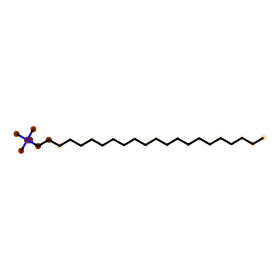

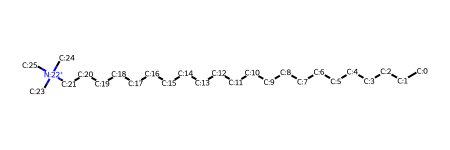

CAS: 9
prediction_Anti_value: 0.9985261
SMILES: CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[08:08:36] The new font size 1 is below the current minimum (6).


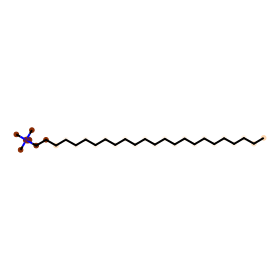

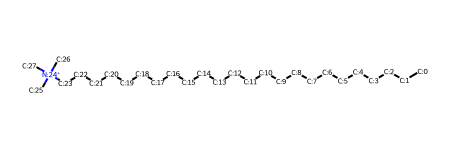

CAS: 10
prediction_Anti_value: 0.9992593
SMILES: CCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


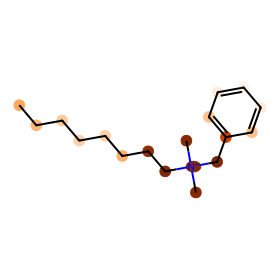

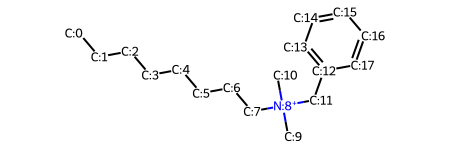

CAS: 11
prediction_Anti_value: 0.99968946
SMILES: CCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


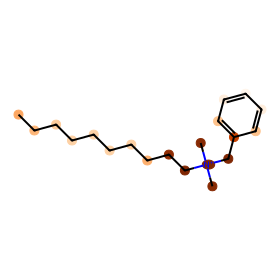

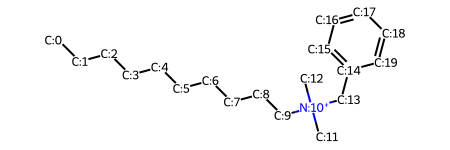

CAS: 12
prediction_Anti_value: 0.99977845
SMILES: CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


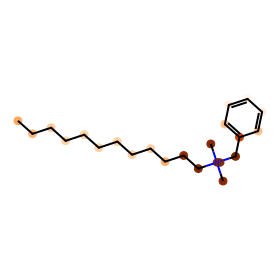

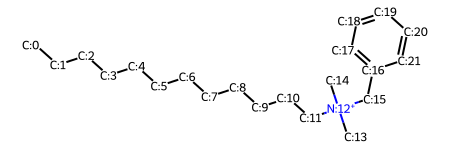

CAS: 13
prediction_Anti_value: 0.99977976
SMILES: CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


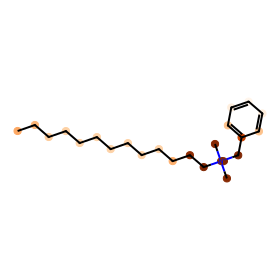

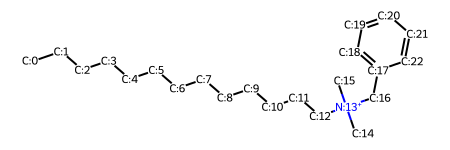

CAS: 14
prediction_Anti_value: 0.99975675
SMILES: CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


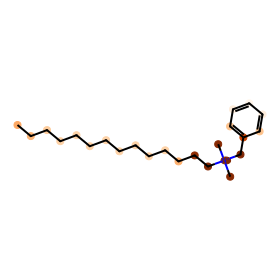

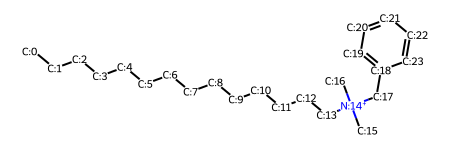

CAS: 15
prediction_Anti_value: 0.99959594
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


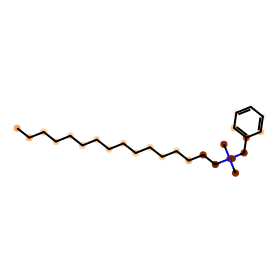

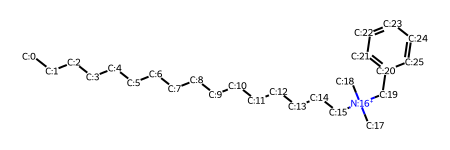

CAS: 16
prediction_Anti_value: 0.99899775
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[08:08:36] The new font size 1 is below the current minimum (6).


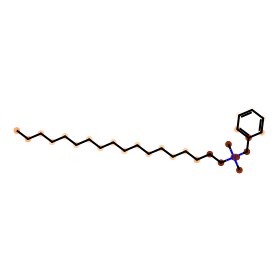

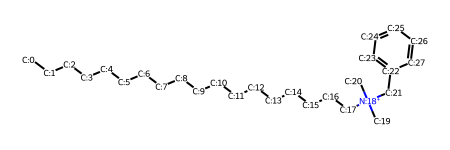

CAS: 17
prediction_Anti_value: 0.99983084
SMILES: CCCCCCCC[N+](C)(C)CCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


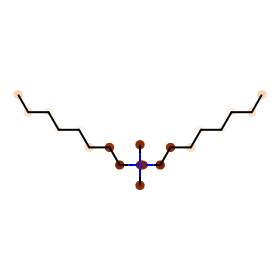

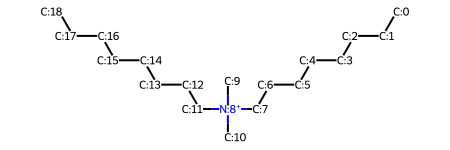

CAS: 18
prediction_Anti_value: 0.9998939
SMILES: CCCCCCCCCC[N+](C)(C)CCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


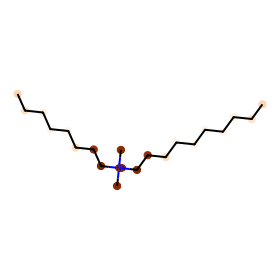

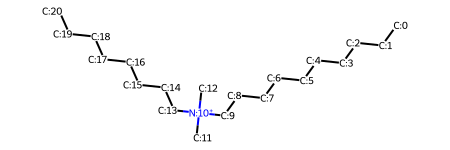

CAS: 19
prediction_Anti_value: 0.99990237
SMILES: CCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


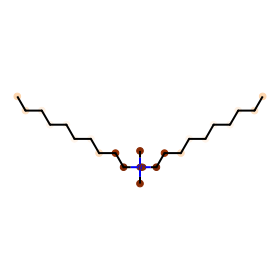

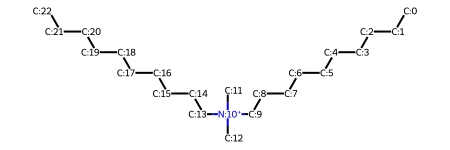

CAS: 20
prediction_Anti_value: 0.9998659
SMILES: CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


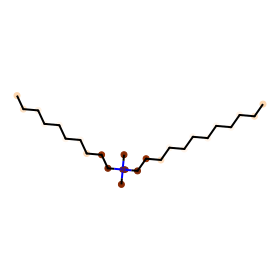

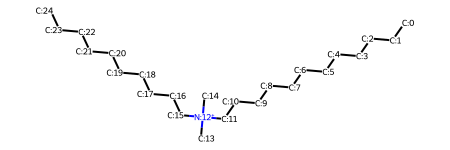

CAS: 21
prediction_Anti_value: 0.99972326
SMILES: CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


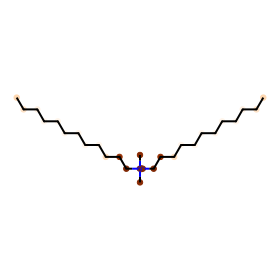

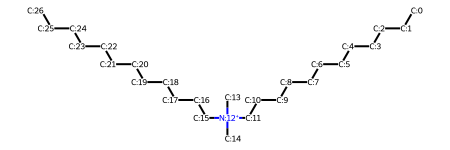

CAS: 22
prediction_Anti_value: 0.9991535
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


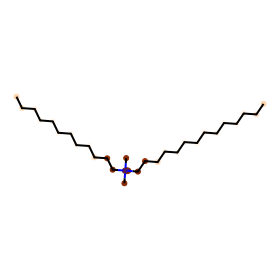

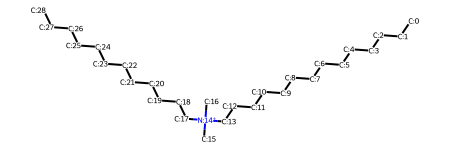

CAS: 23
prediction_Anti_value: 0.9991535
SMILES: CCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


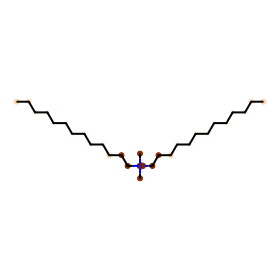

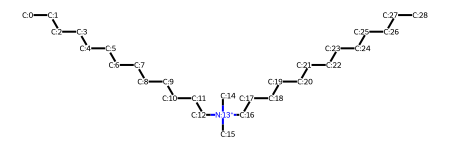

CAS: 24
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


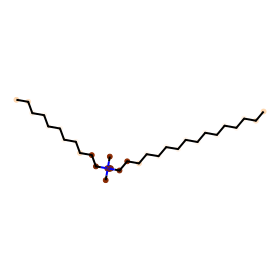

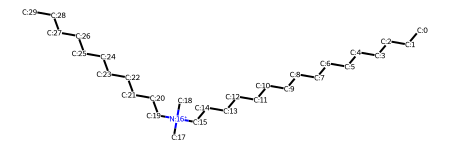

CAS: 25
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


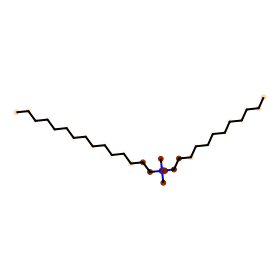

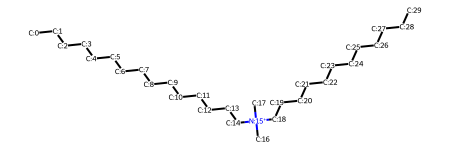

CAS: 26
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC


[08:08:36] The new font size 1 is below the current minimum (6).


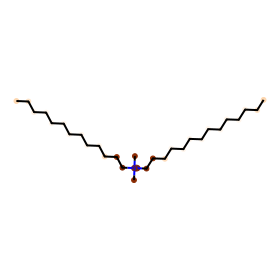

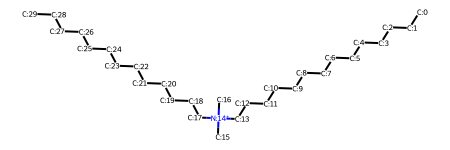

CAS: 27
prediction_Anti_value: 0.9995765
SMILES: CCCCCCCCCCCC[N+](C)(C)CC


[08:08:36] The new font size 1 is below the current minimum (6).


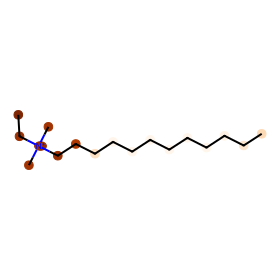

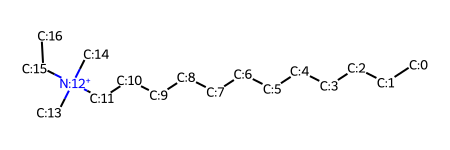

CAS: 28
prediction_Anti_value: 0.9998349
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CC


[08:08:36] The new font size 1 is below the current minimum (6).


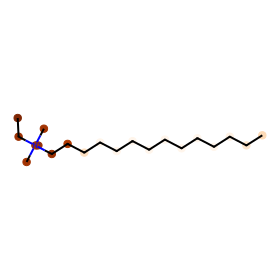

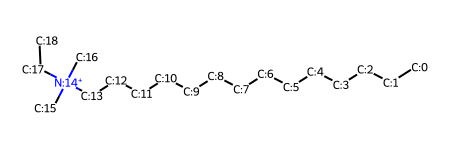

CAS: 29
prediction_Anti_value: 0.99990034
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CC


[08:08:36] The new font size 1 is below the current minimum (6).


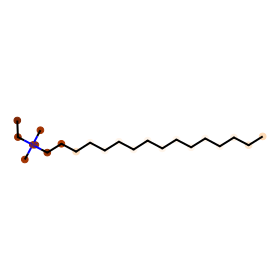

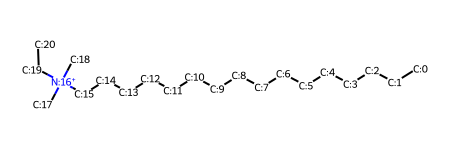

CAS: 30
prediction_Anti_value: 0.9999131
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CC


[08:08:37] The new font size 1 is below the current minimum (6).


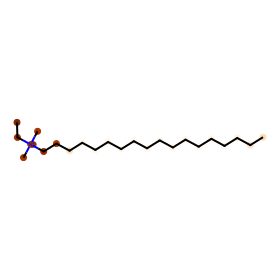

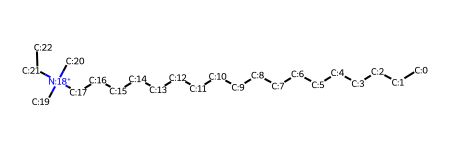

CAS: 31
prediction_Anti_value: 0.9998067
SMILES: CCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1


[08:08:37] The new font size 1 is below the current minimum (6).


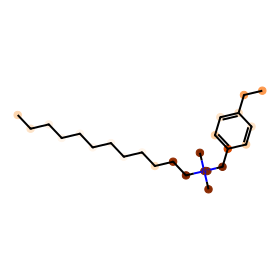

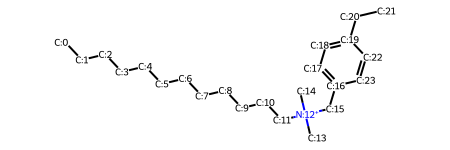

CAS: 32
prediction_Anti_value: 0.9997669
SMILES: CCCCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1


[08:08:37] The new font size 1 is below the current minimum (6).


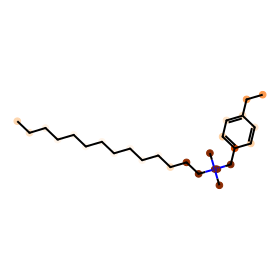

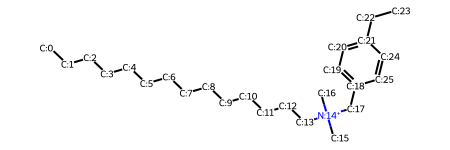

CAS: 33
prediction_Anti_value: 0.9999076
SMILES: CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC


[08:08:37] The new font size 1 is below the current minimum (6).


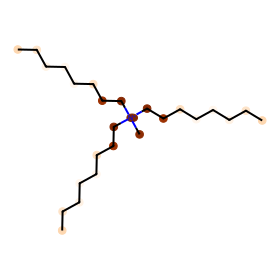

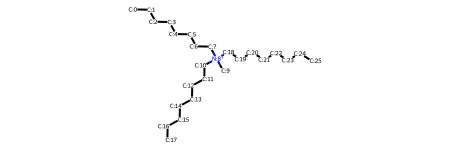

CAS: 34
prediction_Anti_value: 0.99971765
SMILES: CCCCCCCCCCCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


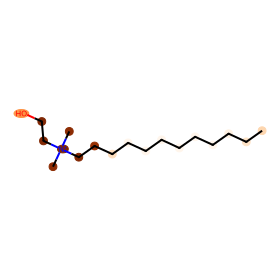

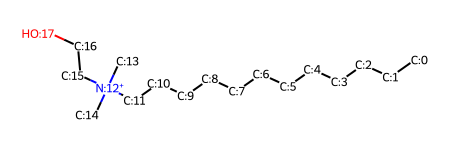

CAS: 35
prediction_Anti_value: 0.9998616
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


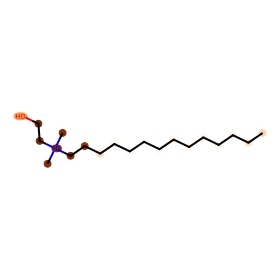

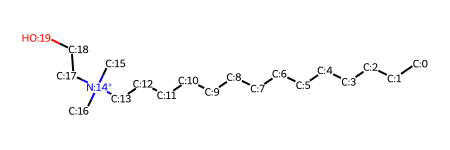

CAS: 36
prediction_Anti_value: 0.999899
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


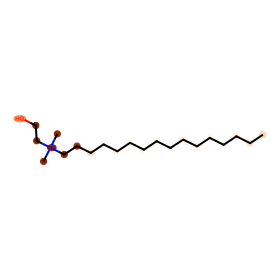

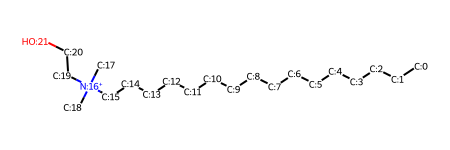

CAS: 37
prediction_Anti_value: 0.9998915
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


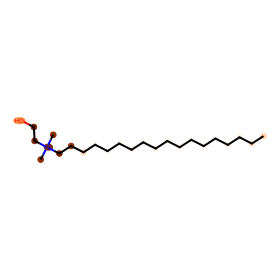

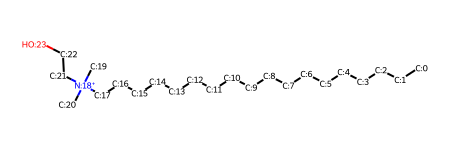

CAS: 38
prediction_Anti_value: 0.9998374
SMILES: CCCCCCCCCCCC[N+](C)(CCO)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


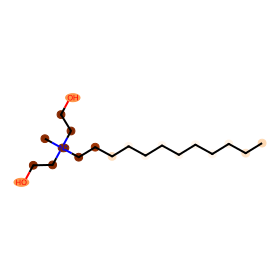

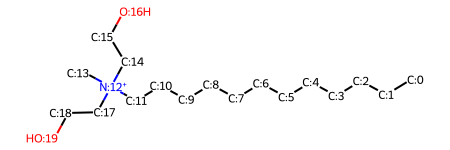

CAS: 39
prediction_Anti_value: 0.99990785
SMILES: CCCCCCCCCCCCCC[N+](C)(CCO)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


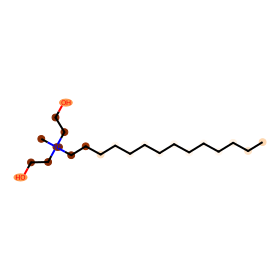

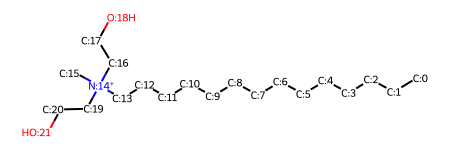

CAS: 40
prediction_Anti_value: 0.99982435
SMILES: CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


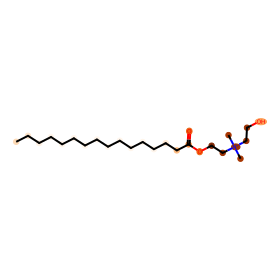

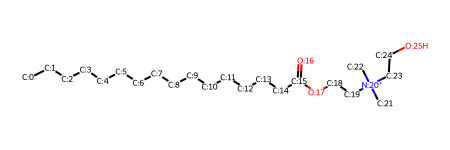

CAS: 41
prediction_Anti_value: 0.9997652
SMILES: CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


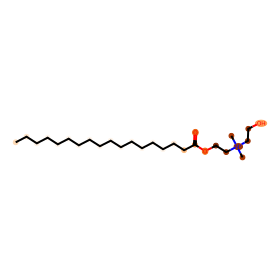

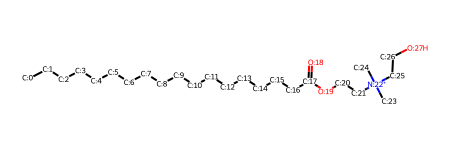

CAS: 42
prediction_Anti_value: 0.9998628
SMILES: CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


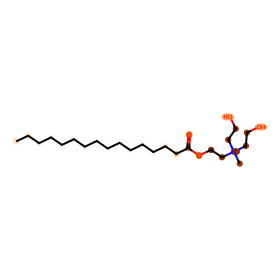

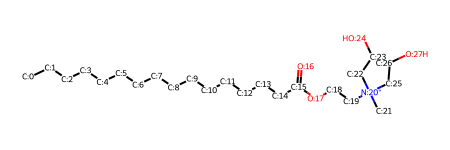

CAS: 43
prediction_Anti_value: 0.99979717
SMILES: CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO


[08:08:37] The new font size 1 is below the current minimum (6).


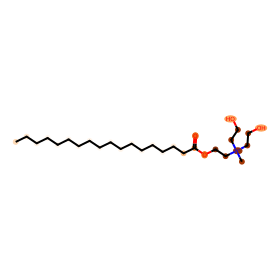

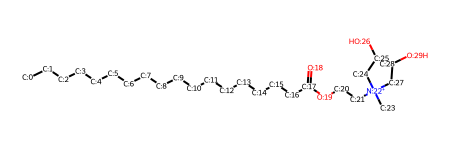

CAS: 44
prediction_Anti_value: 0.99854505
SMILES: CCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[08:08:37] The new font size 1 is below the current minimum (6).


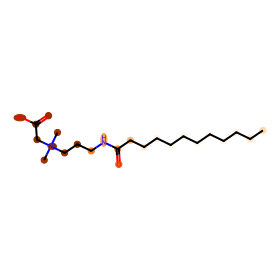

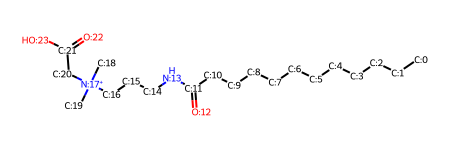

CAS: 45
prediction_Anti_value: 0.9993394
SMILES: CCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[08:08:38] The new font size 1 is below the current minimum (6).


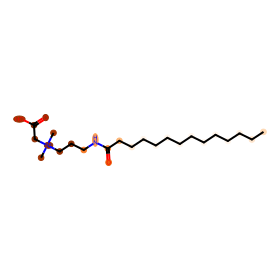

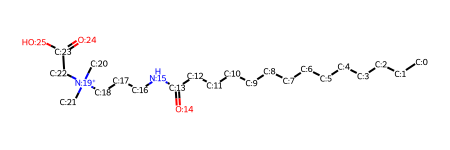

CAS: 46
prediction_Anti_value: 0.99949265
SMILES: CCCCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[08:08:38] The new font size 1 is below the current minimum (6).


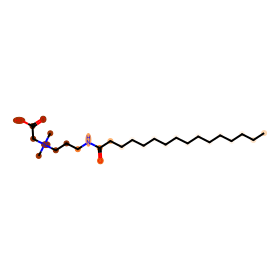

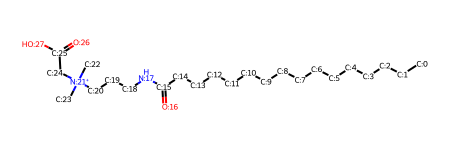

[08:08:38] The new font size 1 is below the current minimum (6).


CAS: 47
prediction_Anti_value: 0.99925953
SMILES: CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc2)cc1


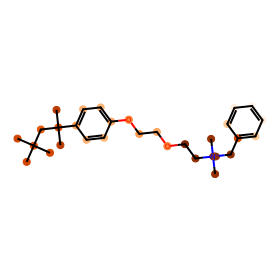

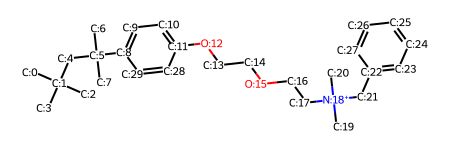

CAS: 48
prediction_Anti_value: 0.9998442
SMILES: CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1


[08:08:38] The new font size 1 is below the current minimum (6).


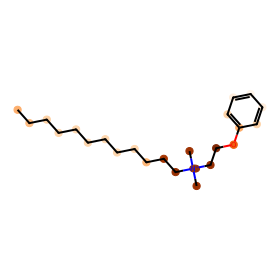

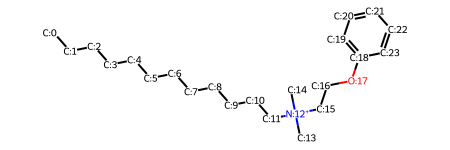

CAS: 49
prediction_Anti_value: 0.99967194
SMILES: CCCCCCCCCCCC[n+]1ccccc1


[08:08:38] The new font size 1 is below the current minimum (6).


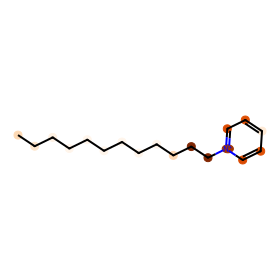

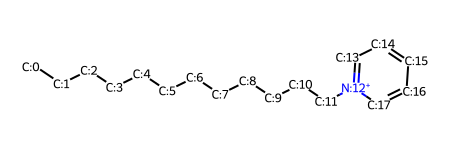

CAS: 50
prediction_Anti_value: 0.99978405
SMILES: CCCCCCCCCCCCCCCC[n+]1ccccc1


[08:08:38] The new font size 1 is below the current minimum (6).


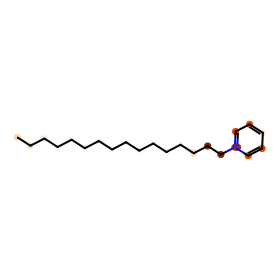

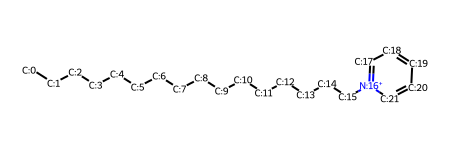

CAS: 51
prediction_Anti_value: 0.99633276
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCC


[08:08:38] The new font size 1 is below the current minimum (6).


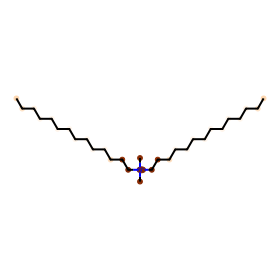

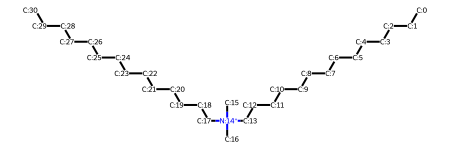

[08:08:38] The new font size 1 is below the current minimum (6).


CAS: 52
prediction_Anti_value: 0.8747281
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCCCC


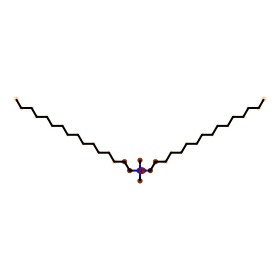

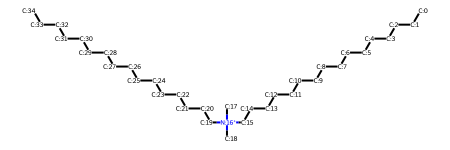

CAS: 53
prediction_Anti_value: 0.11374179
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCCCCCCC


[08:08:38] The new font size 1 is below the current minimum (6).


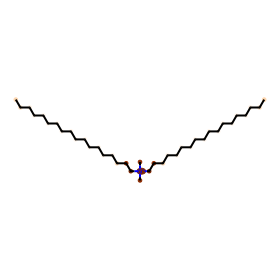

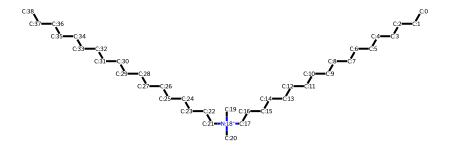

CAS: 54
prediction_Anti_value: 0.99633276
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[08:08:38] The new font size 1 is below the current minimum (6).


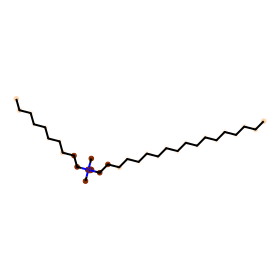

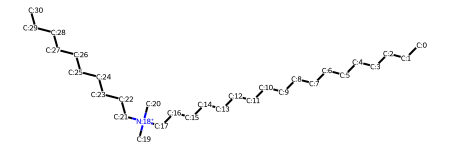

CAS: 55
prediction_Anti_value: 0.99633276
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[08:08:39] The new font size 1 is below the current minimum (6).


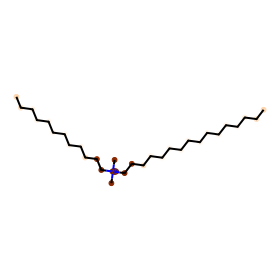

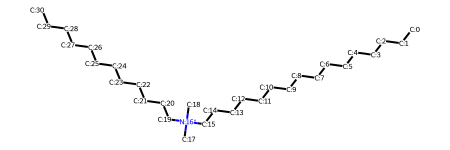

CAS: 56
prediction_Anti_value: 0.99633276
SMILES: CCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC


[08:08:39] The new font size 1 is below the current minimum (6).


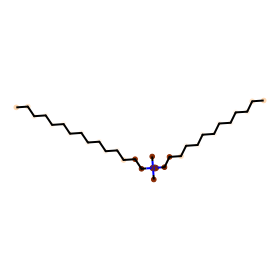

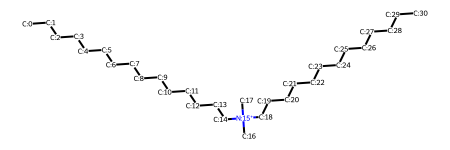

CAS: 57
prediction_Anti_value: 0.2280902
SMILES: CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCOC(=O)CCCCCCCCCCCCCCC


[08:08:39] The new font size 1 is below the current minimum (6).


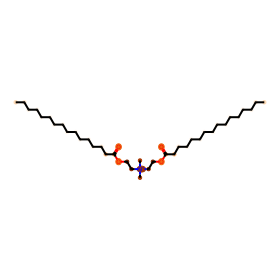

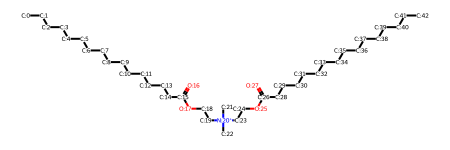

In [ ]:
model_for_viz.eval()
test_MAE_list = []
test_MSE_list = []

out_feature_sorted = []
out_weight_sorted = []
mol_feature_sorted = []


dataset = remained_df
test_MAE_list = []
test_MSE_list = []
valList = np.arange(0,dataset.shape[0])
batch_list = []
a={}

def save_svg_as_file(svg, filename):
    with open(filename, 'w') as f:
        f.write(svg)

for i in range(0, dataset.shape[0], batch_size):
    batch = valList[i:i+batch_size]
    batch_list.append(batch)
for counter, test_batch in enumerate(batch_list):
    batch_df = dataset.loc[test_batch,:]
    smiles_list = batch_df.cano_smiles.values
    #y_val = batch_df[tasks[0]].values

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
    atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
    mol_attention_weight_viz, mol_prediction = model_for_viz(
        torch.Tensor(x_atom), torch.Tensor(x_bonds),
        torch.cuda.LongTensor(x_atom_index),
        torch.cuda.LongTensor(x_bond_index),
        torch.Tensor(x_mask))


    #mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
    y_pred = F.softmax(mol_prediction,dim=-1).data.cpu().numpy()[:,1]
    atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
    atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
    mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

    mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
    for i, smiles in enumerate(smiles_list):
        atom_num = i
        ind_mask = x_mask[i]
        ind_atom = smiles_to_rdkit_list[smiles]
        ind_feature = atom_feature[:, i]
        ind_weight = atom_weight[:, i]
        out_feature = []
        out_weight = []
        for j, one_or_zero in enumerate(list(ind_mask)):
            if one_or_zero == 1.0:
                out_feature.append(ind_feature[:,j])
                out_weight.append(ind_weight[:,j])
#         out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
#         out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])

        mol = Chem.MolFromSmiles(smiles)
        index = dataset[dataset.cano_smiles == smiles].index.tolist()[0]
        CAS_num = dataset.loc[index,'cas']
        label = dataset.loc[index,'Anti']
        print('CAS: '+ str(CAS_num))
        print('prediction_Anti_value: '+str(y_pred[atom_num]))
        #print('Label: '+str(label))
        print('SMILES: '+smiles)
        a[smiles]=[]
        a[smiles].append(str(y_pred[atom_num]))
        a[smiles].append(str(CAS_num))
        #a[smiles].append(str(label))
        ## a[smiles]={str(y_pred[atom_num])}

        weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        import matplotlib.cm as cm
        cmap = cm.get_cmap('Oranges')
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        atom_colors = {}
        weight_norm = np.array(weight_norm).flatten()
        threshold = weight_norm[np.argsort(weight_norm)[0]]
        weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

        #print('Weight_Norm:',weight_norm)
        for i in range(len(ind_atom)):
            atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
        rdDepictor.Compute2DCoords(mol)

        drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
        drawer.SetFontSize(1)
        op = drawer.drawOptions()

        mol = rdMolDraw2D.PrepareMolForDrawing(mol)
        drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
            highlightAtomColors=atom_colors)
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()
        svg2 = svg.replace('svg:','')
        svg3 = SVG(svg2)
        display(svg3)


        filename = str(CAS_num) + '.svg'
        save_svg_as_file(svg, filename)

        display(mol_with_atom_index(mol))

In [ ]:
import os
import matplotlib.pyplot as plt
import cairosvg
from IPython.display import SVG


def save_svg_as_file(svg, filename):
    with open(filename, 'w') as f:
        f.write(svg)


# 其他代码...

# 生成colorbar
scatter = plt.scatter([], [], c=[], cmap='Oranges', norm=norm)
plt.colorbar(scatter)

# 保存colorbar为SVG格式
colorbar_filename = 'colorbar.svg'
plt.savefig(colorbar_filename, format='svg')
plt.close()

# 其他代码...

# 在此处添加保存着色后的colorbar的代码，如保存为SVG格式的文件
# 使用 save_svg_as_file 函数保存生成的 SVG 文件

# 其他代码...


In [ ]:
!apt-get update
!apt-get install -y inkscape

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,359 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,282 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packag

In [ ]:
!inkscape --version

Inkscape 0.92.5 (2060ec1f9f, 2020-04-08)


In [ ]:
import os


# 循环遍历文件夹中的 SVG 文件，并转换为 TIFF 格式
input_folder = './svg'
output_folder = './tiff'
# 确保输出文件夹存在
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 遍历输入文件夹中的所有文件
for filename in os.listdir(input_folder):
    if filename.endswith('.svg'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.tiff')

        # 使用 Inkscape 将 SVG 转换为 TIFF，并指定分辨率为 300dpi
        os.system(f'inkscape -z -f {input_path} -e {output_path} -d 300')

        print(f'Converted {input_path} to {output_path}')


Converted ./svg/2802.svg to ./tiff/2802.tiff
Converted ./svg/2801.svg to ./tiff/2801.tiff
Converted ./svg/2800.svg to ./tiff/2800.tiff
Converted ./svg/2799.svg to ./tiff/2799.tiff
Converted ./svg/2798.svg to ./tiff/2798.tiff
Converted ./svg/2797.svg to ./tiff/2797.tiff
Converted ./svg/2796.svg to ./tiff/2796.tiff
Converted ./svg/2795.svg to ./tiff/2795.tiff
Converted ./svg/2794.svg to ./tiff/2794.tiff
Converted ./svg/2793.svg to ./tiff/2793.tiff
Converted ./svg/2792.svg to ./tiff/2792.tiff
Converted ./svg/2867.svg to ./tiff/2867.tiff
Converted ./svg/2860.svg to ./tiff/2860.tiff
Converted ./svg/2864.svg to ./tiff/2864.tiff
Converted ./svg/2861.svg to ./tiff/2861.tiff
Converted ./svg/2791.svg to ./tiff/2791.tiff
Converted ./svg/2790.svg to ./tiff/2790.tiff
Converted ./svg/2789.svg to ./tiff/2789.tiff
Converted ./svg/2863.svg to ./tiff/2863.tiff
Converted ./svg/2868.svg to ./tiff/2868.tiff
Converted ./svg/2862.svg to ./tiff/2862.tiff
Converted ./svg/2865.svg to ./tiff/2865.tiff
Converted 

In [ ]:
import os
import openpyxl
from openpyxl.drawing.image import Image
from PIL import Image as PILImage

# 设置文件夹路径和Excel文件路径
folder_path = './tiff'  # 文件夹路径
excel_file = 'output.xlsx'  # Excel文件名

# 创建一个新的Excel工作簿
workbook = openpyxl.Workbook()
sheet = workbook.active

# 获取文件夹中的图片文件列表
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# 遍历图片文件列表
for i, image_file in enumerate(image_files):
    # 获取图片文件的完整路径
    image_path = os.path.join(folder_path, image_file)

    # 将图片文件插入到Excel中
    img = PILImage.open(image_path)
    img_width, img_height = img.size
    excel_img = Image(image_path)
    excel_img.width = img_width
    excel_img.height = img_height

    # 将图片粘贴到指定单元格
    sheet.add_image(excel_img, f'B{i+2}')

    # 在另一列中添加图片文件名作为编号
    sheet[f'A{i+2}'] = image_file

# 保存Excel文件
workbook.save(excel_file)

In [ ]:
import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# 设置文件夹路径和Excel文件名
folder_path = './tiff'  # 文件夹路径
excel_file = 'output.xlsx'  # Excel文件名

# 创建一个新的Excel工作簿并选择活动工作表
workbook = Workbook()
sheet = workbook.active

# 遍历文件夹中的TIFF图像文件
for filename in os.listdir(folder_path):
    if filename.endswith('.tiff') or filename.endswith('.tif'):
        image_path = os.path.join(folder_path, filename)
        img = Image(image_path)
        sheet.add_image(img, 'A1')

# 保存Excel文件
workbook.save(excel_file)

In [ ]:
with open('Anti_plus_v2_test_ROC.csv','w') as f:
    f.write('SMILES'+ ','+'y_pred_adjust'+ ','+'CAS'+ ','+'Anti\n')
    for key in a:
        f.write(key + ',' + str(a[key][0])+ ',' + str(a[key][1]) +',' + str(a[key][2]) +'\n')

In [ ]:
with open('QAC_identify_predict.csv','w') as f:
    f.write('SMILES'+ ','+'y_pred_adjust'+ ','+'CAS\n')
    for key in a:
        f.write(key + ',' + str(a[key][0])+ ',' + str(a[key][1]) +'\n')

In [ ]:
test_df.to_csv('Anti_test.csv')

In [ ]:
train_df.to_csv('Anti_train.csv')

In [ ]:
with open('QAC_Anti_predict.tab','w') as f:
    f.write('SMILES\t'+'y_pred_adjust\t'+'CAS\n')
    for key in a:
        f.write(key + '\t' + str(a[key][0])+ '\t' + str(a[key][1]) +'\n')